In [1]:
from deepface import DeepFace
import torch
from tqdm import tqdm
import os, random
import math
from pathlib import Path
from PIL import Image
from numpy import var
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from transformers import CLIPProcessor, CLIPModel
import json
import itertools
from scipy.spatial.distance import euclidean
from scipy.spatial import distance
from torch import Tensor

In [2]:
#checkpoints
FOLDER = "Checkpoints"
FILE = "ckpt.json"

DATASET = "./GDatasetSplitFolders/train"
VALDS = "./GDatasetSplitFolders/val"

MODELS = [
  "VGG-Face",
  "Facenet",
  "Facenet512",
  "OpenFace",
  "DeepFace",
  "DeepID",
  "ArcFace",
  "Dlib",
  "SFace",
  "GhostFaceNet",
]

In [3]:
#DATA
WEIGHTS = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
MIN_ID = ['2', '3', '4', '5', '6', '7', '8', '9', '10']
Ss = ['1.05', '1.07','1.08','1.1','1.15','1.2', '1.25', '1.3' , '1.35']
THRESHOLD = ['0','0.1', '0.12', '0.14', '0.16', '0.18', '0.2', '0.22', '0.24', '0.26', '0.28', '0.3', '0.32', '0.34', '0.36', '0.38', '0.4', '0.45', '0.5', '0.52', '0.54', '0.56', '0.58', '0.6', '0.62', '0.64', '0.66', '0.68', '0.7', '0.72', '0.74', '0.76', '0.78', '0.8', '0.82', '0.84', '0.86', '0.88', '0.9', '0.92', '0.94', '0.96', '0.98', '1']

In [4]:
def cosine_similarity(a, b):
    """
    Cosine similarity normalized to [0, 1].
    """
    return torch.functional.F.cosine_similarity(a, b, dim=0)

def exponential_similarity(a: Tensor, b: Tensor) -> float:
    """
    Exponential similarity from Euclidean distance.
    """
    dist = torch.dist(a, b, p=2)  # Euclidean distance
    return torch.exp(-dist**2).item()

def sigmoid_similarity(a: Tensor, b: Tensor, t: float = 0.5) -> float:
    """
    Sigmoid normalized Euclidean similarity.
    """
    dist = torch.dist(a, b, p=2)  # Euclidean distance
    return (1 / (1 + torch.exp(dist - t))).item()

def dice_similarity(a: Tensor, b: Tensor) -> float:
    """
    Dice similarity coefficient.
    """
    numerator = 2 * torch.dot(a, b)
    denominator = torch.sum(a**2) + torch.sum(b**2)
    return (numerator / denominator).item()

def jaccard_similarity(a: Tensor, b: Tensor) -> float:
    """
    Jaccard similarity for embeddings.
    Note: Works best if embeddings are non-negative.
    """
    min_sum = torch.sum(torch.min(a, b))
    max_sum = torch.sum(torch.max(a, b))
    return (min_sum / max_sum).item()

def normalized_cross_correlation(a: Tensor, b: Tensor) -> float:
    """
    Normalized cross-correlation similarity.
    """
    a_mean = torch.mean(a)
    b_mean = torch.mean(b)
    numerator = torch.sum((a - a_mean) * (b - b_mean))
    denominator = torch.sqrt(torch.sum((a - a_mean)**2) * torch.sum((b - b_mean)**2))
    sim = numerator / denominator
    return ((sim + 1) / 2).item()  # Normalize to [0, 1]

In [5]:
class TFRecognition:
    #Checkpoints
    FOLDER = "Checkpoints"
    FILE = "ckpt.json"
    #generic data
    model = ""
    TrainDs =""
    ValDs = ""
    weights = []
    SIMILARITIES = 6

    BAN_FREQ = 5
    #constructor
    def __init__(self, model, TrainDs, ValDs, weights):
        self.model = model
        self.TrainDs = TrainDs
        self.ValDs = ValDs
        self.weights = weights

        weights = [float(i) for i in weights]
        all_combinations = itertools.product(weights, repeat=self.SIMILARITIES)

        # Filter combinations where the sum of elements is 1
        valid_combinations = [combination for combination in all_combinations if sum(combination) == 1.0]

        # Print the valid combinations
        self.weights = valid_combinations

    def Similarity(self, a, b, weights):
        sim_cosine = cosine_similarity(a, b)
        sim_exponential = exponential_similarity(a, b)
        sim_sigmoid = sigmoid_similarity(a, b)
        sim_dice = dice_similarity(a, b)
        sim_jaccard = jaccard_similarity(a, b)
        sim_ncc = normalized_cross_correlation(a, b)
        final_score = (
        weights[0] * sim_cosine +
        weights[1] * sim_exponential +
        weights[2] * sim_sigmoid +
        weights[3] * sim_dice +
        weights[4] * sim_jaccard +
        weights[5] * sim_ncc
        )
        return final_score
    
    #utilities
    def count_files_in_directory(self, directory):
        # Create a Path object
        path = Path(directory)
        # Count only files (ignoring subdirectories)
        return sum(1 for f in path.iterdir() if f.is_file())

    def Represent(self, path):
        embedding_objs = DeepFace.represent(
        img_path = path,
        model_name= self.model,
        enforce_detection=False,
        )
        SUT_embeddings = embedding_objs[0]['embedding']
        return torch.FloatTensor(SUT_embeddings)
    
    def CheckForCheckpoints(self):
        if os.path.exists(os.path.join(self.FOLDER, self.FILE)):
            with open(os.path.join(self.FOLDER, self.FILE), 'r') as f:
                data = json.load(f)
            return data
        else:
            os.makedirs(self.FOLDER, exist_ok=True)
            with open(os.path.join(self.FOLDER, self.FILE), 'w') as f:
                json.dump({}, f)
            return False
        
    def Save(self, acc, identity):
        data = {}
        data['id'] = identity
        data['acc'] = acc
        
        with open(os.path.join(self.FOLDER, self.FILE), 'w') as f:
            json.dump(data, f)

    #train the model

    def ProcessIdentity(self, realRef, fakeFolder, acc, THRESHOLD):
        rep = {}
        repFake = {}
        for real in os.listdir(realRef):
            rep[real] = self.Represent(os.path.join(realRef, real))      
        for fake in os.listdir(fakeFolder):
            repFake[fake] = self.Represent(os.path.join(fakeFolder, fake))
        #fake evaluation
        for w in self.weights:
            index = self.weights.index(w)
            for fake in repFake.keys():
                distance = 0
                for real in rep.keys(): 
                    sim = self.Similarity(rep[real], repFake[fake], w) 
                    distance = max(sim, distance)

                for threshold in THRESHOLD:
                    if(distance > float(threshold)):
                        acc[threshold][str(index)]['FP'] += 1
                    else:
                        acc[threshold][str(index)]['TN'] += 1 

        #pick random real images and perform evaluation
        toEval = self.count_files_in_directory(fakeFolder)
        
        for w in self.weights:
            i = 0
            index = self.weights.index(w)
            for randomReal in rep.keys():
                if(i == toEval):
                    break
                i += 1
                distance = 0
                for real in rep.keys():
                    if(real == randomReal):
                        continue
                    sim = self.Similarity(rep[randomReal], rep[real], w)
                    distance = max(sim, distance)
                
                for threshold in THRESHOLD:
                    if(distance > float(threshold)):
                        acc[threshold][str(index)]['TP'] += 1
                    else:
                        acc[threshold][str(index)]['FN'] += 1     

        return acc

    def PlotResults(self, bestData):
        print("plotting")
        TP = bestData['TP']
        TN = bestData['TN']
        FP = bestData['FP']
        FN = bestData['FN']
        f1 = bestData['F1']
        acc = bestData['accuracy']
        t = bestData['treshold']

        # Plot the ROC curve
        plt.figure(figsize=(12, 5))
        # Add labels and title
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('ROC Curve')
    
        cm = np.array([[TN, FP], [FN, TP]])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Positive', 'Predicted Negative'],
                yticklabels=['Actual Positive', 'Actual Negative'])
        plt.title(f'Confusion Matrix (Threshold = {t})')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')

        # Show the plot
        plt.tight_layout()
        
        #return the threshold having the best accuracy and the threshold having the best F1 score   
        #Print The results
        print("Model: ", self.model)
        print("Threshold:", t)
        print("F1 score: ", f1)
        print("Accuracy: ", acc)
        print('WEIGHTS:', bestData['WEIGHTS'])
        plt.show()

    def ComputeBestResults(self, acc, thresholds):
        print("computing best results")
        bestF1 = 0
        best = {'TP':0, 'TN':0, 'FP':0, 'FN':0}
        for t in thresholds:   
            for w in self.weights:     
                index = self.weights.index(w)     
                TP = acc[t][str(index)]['TP']
                TN = acc[t][str(index)]['TN']
                FP = acc[t][str(index)]['FP']
                FN = acc[t][str(index)]['FN']

                    
                precision = TP / (TP + FP) if (TP + FP) != 0 else 0
                recall = TP / (TP + FN) if (TP + FN) != 0 else 0
                accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
                
                if(f1 > bestF1):    
                    bestF1 = f1               
                    best = {'TP':TP, 'TN':TN, 'FP':FP, 'FN':FN, 'F1':f1, 'accuracy': accuracy, 'WEIGHTS': w, 'treshold': t}

        return best

    def Validate(self, w, threshold):
        best = {'TP':0, 'TN':0, 'FP':0, 'FN':0}
        for identity in tqdm(os.listdir(self.ValDs), "evaluating images",position=0, leave=True):    
            realRef = os.path.join(self.ValDs, identity, 'real')
            fakeFolder = os.path.join(self.ValDs, identity, 'fake')

            rep = {}
            repFake = {}
            for real in os.listdir(realRef):
                rep[real] = self.Represent(os.path.join(realRef, real))      
            for fake in os.listdir(fakeFolder):
                repFake[fake] = self.Represent(os.path.join(fakeFolder, fake))
            #fake evaluation

            for fake in repFake.keys():
                distance = 0
                for real in rep.keys(): 
                    sim = self.Similarity(rep[real], repFake[fake], w) 
                    distance = max(sim, distance)

                if(distance > float(threshold)):
                    best['FP'] += 1
                else:
                    best['TN'] += 1 

            #pick random real images and perform evaluation
            toEval = self.count_files_in_directory(fakeFolder)
            i = 0                 
            for randomReal in rep.keys():           
                if(i == toEval):
                    break
                i += 1
                distance = 0
                for real in rep.keys():
                    if(real == randomReal):
                        continue
                    sim = self.Similarity(rep[randomReal], rep[real], w)
                    distance = max(sim, distance)
                
                if(distance > float(threshold)):
                    best['TP'] += 1
                else:
                    best['FN'] += 1 

        #compute accuracy and F1
        TP = best['TP']
        TN = best['TN']
        FP = best['FP']
        FN = best['FN']
        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        best['F1'] = f1
        best['accuracy'] = accuracy
        best['WEIGHTS'] = w
        best['treshold'] = threshold
        
        self.PlotResults(best)

    def InitAcc(self, Thresholds):
        acc = {}
        for t in Thresholds:
            acc[t] = {}
            for w in self.weights:
                index = self.weights.index(w)
                acc[t][str(index)] = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}

        return acc
    
    def train(self, Thresholds):
        if(self.TrainDs == "" or self.ValDs == ""):
            print("No dataset provided")
            return
        elif(self.model == ""):
            print("No model provided")
            return
        if(not isinstance(Thresholds, list)):
            print("Thresholds should be a list")
            return
        
        #estimate the thresholds
        ckp = self.CheckForCheckpoints()
        acc = {}
        LastIdentity = ""

        if(ckp):
            print("test")
            acc = ckp['acc']
            LastIdentity = ckp['id']
            
        else:
            #create checkpoint file
            acc = self.InitAcc(Thresholds)
            LastIdentity = ""

        for identity in tqdm(os.listdir(self.TrainDs), "evaluating images",position=0, leave=True):

            if(identity <= LastIdentity):
                continue
            
            realRef = os.path.join(self.TrainDs, identity, 'real')
            fakeFolder = os.path.join(self.TrainDs, identity, 'fake')
            acc = self.ProcessIdentity(realRef, fakeFolder, acc, Thresholds)
            #save the checkpoint

            self.Save(acc, identity)      

        #remove checkpoints
        #os.remove(os.path.join(self.FOLDER, self.FILE)) 
        self.PlotResults(self.ComputeBestResults(acc, Thresholds))

class TFSens(TFRecognition):
    #Checkpoints
    FOLDER = "Checkpoints"
    FILE = "ckpt.json"
    #generic data
    model = ""
    TrainDs =""
    ValDs = ""
    sensibility = []
    MinIDs = []
    weights = []
    def __init__(self, model, TrainDs, ValDs, Sensibility, MinIDs, weights):
        self.TrainDs  = TrainDs
        self.ValDs = ValDs
        self.model = model
        self.sensibility = Sensibility
        self.MinIDs = MinIDs
        self.weights = weights

    def InitAcc(self, Thresholds):
        acc = {}
        for t in Thresholds:
            acc[t] = {}
            for s in self.sensibility:
                acc[t][s] = {}
                for m in self.MinIDs:
                    acc[t][s][m] = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
        return acc

    def ProcessIdentity(self, realRef, fakeFolder, acc, THRESHOLD):
        rep = {}
        repFake = {}
        for real in os.listdir(realRef):
            rep[real] = self.Represent(os.path.join(realRef, real))      
        for fake in os.listdir(fakeFolder):
            repFake[fake] = self.Represent(os.path.join(fakeFolder, fake))
        #fake evaluation
        img_eval = 0
        for fake in repFake.keys():
            distance = 0
            simList = []
            img_eval += 1

            for real in rep.keys(): 
                sim = self.Similarity(rep[real], repFake[fake], self.weights) 
                distance = max(sim, distance)
                simList.append(sim)

            for threshold in THRESHOLD:
                for s in self.sensibility:
                    for id in self.MinIDs:
                        if(distance > float(threshold) * float(s)):
                            acc[threshold][s][id]['FP'] += 1
                        else:
                            acceptables = 0
                            for sim in simList:
                                if(sim > float(threshold)):
                                    acceptables += 1
                                if(acceptables >= float(id)):
                                    break
                            
                            if(acceptables >= float(id)):
                                acc[threshold][s][id]['FP'] += 1
                            else:
                                acc[threshold][s][id]['TN'] += 1
                                

        #pick random real images and perform evaluation
        toEval = self.count_files_in_directory(fakeFolder)
        i = 0
        for randomReal in rep.keys():
            if(i == toEval):
                break
            img_eval += 1
            i += 1
            distance = 0
            simList = []
            for real in rep.keys():
                if(real == randomReal):
                    continue
                sim = self.Similarity(rep[randomReal], rep[real], self.weights)
                distance = max(sim, distance)
                simList.append(sim)
        
            for threshold in THRESHOLD:
                for s in self.sensibility:
                    for id in self.MinIDs:              
                        if(distance > float(threshold) * float(s)): 
                            acc[threshold][s][id]['TP'] += 1
                        else:
                            acceptables = 0
                            for sim in simList:
                                if(sim > float(threshold)):
                                    acceptables += 1
                                if(acceptables >= float(id)):
                                    break
                            if(acceptables >= float(id)):
                                acc[threshold][s][id]['TP'] += 1
                            else:
                                acc[threshold][s][id]['FN'] += 1

        print("Images evaluated: ", img_eval)
        
        return acc
    
    def PlotResults(self, bestData):
        print("plotting")
        TP = bestData['TP']
        TN = bestData['TN']
        FP = bestData['FP']
        FN = bestData['FN']
        f1 = bestData['F1']
        acc = bestData['accuracy']
        t = bestData['treshold']

        # Plot the ROC curve
        plt.figure(figsize=(12, 5))
        # Add labels and title
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('ROC Curve')
    
        cm = np.array([[TN, FP], [FN, TP]])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Positive', 'Predicted Negative'],
                yticklabels=['Actual Positive', 'Actual Negative'])
        plt.title(f'Confusion Matrix (Threshold = {t})')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')

        # Show the plot
        plt.tight_layout()
        
        #return the threshold having the best accuracy and the threshold having the best F1 score   
        #Print The results
        print("Model: ", self.model)
        print("Threshold:", t)
        print("F1 score: ", f1)
        print("Accuracy: ", acc)
        print("sens", bestData['s'])
        print("id", bestData['id'])
        plt.show()
        
    def Validate(self, threshold, s , ids):
        best = {'TP':0, 'TN':0, 'FP':0, 'FN':0}
        for identity in tqdm(os.listdir(self.ValDs), "evaluating images",position=0, leave=True):    
            realRef = os.path.join(self.ValDs, identity, 'real')
            fakeFolder = os.path.join(self.ValDs, identity, 'fake')

            rep = {}
            repFake = {}
            for real in os.listdir(realRef):
                rep[real] = self.Represent(os.path.join(realRef, real))      
            for fake in os.listdir(fakeFolder):
                repFake[fake] = self.Represent(os.path.join(fakeFolder, fake))
            #fake evaluation

            for fake in repFake.keys():
                distance = 0
                simList = []
                for real in rep.keys(): 
                    sim = self.Similarity(rep[real], repFake[fake], self.weights) 
                    distance = max(sim, distance)
                    simList.append(sim)
                
                if(distance > float(threshold) * float(s)):
                    best['FP'] += 1
                else:
                    acceptables = 0
                    for sim in simList:
                        if(sim < float(threshold) * float(s)):
                            acceptables += 1
                        if(acceptables >= float(ids)):
                            break
                    if(acceptables >= float(ids)):
                        best['FP'] += 1
                    else:
                        best['TN'] += 1 

            #pick random real images and perform evaluation
            toEval = self.count_files_in_directory(fakeFolder)
            i = 0                 
            for randomReal in rep.keys():           
                if(i == toEval):
                    break
                i += 1
                distance = 0
                simList = []
                for real in rep.keys():
                    if(real == randomReal):
                        continue
                    sim = self.Similarity(rep[randomReal], rep[real], self.weights)
                    distance = max(sim, distance)
                    simList.append(sim)
                
                if(distance > float(threshold) * float(s)):
                    best['TP'] += 1
                else:
                    acceptables = 0
                    for sim in simList:
                        if(sim < float(threshold) * float(s)):
                            acceptables += 1
                        if(acceptables >= float(ids)):
                            break
                    if(acceptables >= float(ids)):
                        best['TP'] += 1
                    else:
                        best['FN'] += 1                     

        #compute accuracy and F1
        TP = best['TP']
        TN = best['TN']
        FP = best['FP']
        FN = best['FN']
        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        best['F1'] = f1
        best['accuracy'] = accuracy
        best['WEIGHTS'] = self.weights
        best['treshold'] = threshold
        best['s'] = s
        best['id'] = ids
        self.PlotResults(best)

    def ComputeBestResults(self, acc, thresholds):
        print("computing best results")
        bestF1 = 0
        best = {'TP':0, 'TN':0, 'FP':0, 'FN':0}
        for t in thresholds:   
            for s in self.sensibility:
                for id in self.MinIDs:    
                    TP = acc[t][s][id]['TP']
                    TN = acc[t][s][id]['TN']
                    FP = acc[t][s][id]['FP']
                    FN = acc[t][s][id]['FN']

                        
                    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
                    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
                    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0
                    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
                    
                    if(f1 > bestF1):    
                        bestF1 = f1               
                        best = {'TP':TP, 'TN':TN, 'FP':FP, 'FN':FN, 'F1':f1, 'accuracy': accuracy, 's': s, 'treshold': t, 'id': id}

        if(best['TP'] + best['TN'] + best['FP'] + best['FN'] > 2200):
            print("Fatal Error! The model is not working properly")
            exit()
        return best
    
class TFSensUnFreezed(TFRecognition):
    #Checkpoints
    FOLDER = "Checkpoints"
    FILE = "ckpt.json"
    #generic data
    model = ""
    TrainDs =""
    ValDs = ""
    sensibility = []
    MinIDs = []
    weights = []
    SIMILARITIES = 4
    
    def __init__(self, model, TrainDs, ValDs, Sensibility, MinIDs, weights):
        super().__init__(model, TrainDs, ValDs, weights)
        self.TrainDs  = TrainDs
        self.ValDs = ValDs
        self.model = model
        self.sensibility = Sensibility
        self.MinIDs = MinIDs

    def InitAcc(self, Thresholds):
        acc = {}
        for t in Thresholds:
            acc[t] = {}
            for s in self.sensibility:
                acc[t][s] = {}
                for m in self.MinIDs:
                    acc[t][s][m] = {}
                    for w in self.weights:
                        index = self.weights.index(w)
                        acc[t][s][m][str(index)] = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}

        return acc

    def Similarity(self, a, b, weights):
        sim_cosine = cosine_similarity(a, b)
        sim_sigmoid = sigmoid_similarity(a, b)
        sim_dice = dice_similarity(a, b)
        sim_ncc = normalized_cross_correlation(a, b)

        final_score = (
        weights[0] * sim_cosine +
        weights[1] * sim_sigmoid +
        weights[2] * sim_dice +
        weights[3] * sim_ncc
        )
        return final_score
    
    def ProcessIdentity(self, realRef, fakeFolder, acc, THRESHOLD):
        rep = {}
        repFake = {}
        for real in os.listdir(realRef):
            rep[real] = self.Represent(os.path.join(realRef, real))      
        for fake in os.listdir(fakeFolder):
            repFake[fake] = self.Represent(os.path.join(fakeFolder, fake))
        #fake evaluation
        for w in self.weights:
            index = self.weights.index(w)
      
            for fake in repFake.keys():
                distance = 0
                simList = []
                for real in rep.keys(): 
                    sim = self.Similarity(rep[real], repFake[fake], w) 
                    distance = max(sim, distance)
                    simList.append(sim)

                for threshold in THRESHOLD:
                    for s in self.sensibility:
                        for id in self.MinIDs:
                            if(distance > float(threshold) * float(s)):
                                acc[threshold][s][id][str(index)]['FP'] += 1
                            else:
                                acceptables = 0
                                for sim in simList:
                                    if(sim > float(threshold)):
                                        acceptables += 1
                                    if(acceptables >= float(id)):
                                        break
                                if(acceptables >= float(id)):
                                    acc[threshold][s][id][str(index)]['FP'] += 1
                                else:
                                    acc[threshold][s][id][str(index)]['TN'] += 1
                                

        #pick random real images and perform evaluation
            toEval = self.count_files_in_directory(fakeFolder)
            
            i = 0
            
            for randomReal in rep.keys():
                if(i == toEval):
                    break
                i += 1
                distance = 0
                simList = []
                for real in rep.keys():
                    if(real == randomReal):
                        continue
                    sim = self.Similarity(rep[randomReal], rep[real], w)
                    distance = max(sim, distance)
                    simList.append(sim)

                for threshold in THRESHOLD:
                    for s in self.sensibility:
                        for id in self.MinIDs:
                            if(distance > float(threshold) * float(s)): 
                                acc[threshold][s][id][str(index)]['TP']+= 1
                            else:
                                acceptables = 0
                                for sim in simList:
                                    if(sim > float(threshold)):
                                        acceptables += 1
                                    if(acceptables >= float(id)):
                                        break
                                if(acceptables >= float(id)):
                                    acc[threshold][s][id][str(index)]['TP'] += 1
                                else:
                                    acc[threshold][s][id][str(index)]['FN'] += 1

        return acc
    
    def PlotResults(self, bestData):
        print("plotting")
        TP = bestData['TP']
        TN = bestData['TN']
        FP = bestData['FP']
        FN = bestData['FN']
        f1 = bestData['F1']
        acc = bestData['accuracy']
        t = bestData['treshold']

        # Plot the ROC curve
        plt.figure(figsize=(12, 5))
        # Add labels and title
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('ROC Curve')
    
        cm = np.array([[TN, FP], [FN, TP]])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Positive', 'Predicted Negative'],
                yticklabels=['Actual Positive', 'Actual Negative'])
        plt.title(f'Confusion Matrix (Threshold = {t})')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')

        # Show the plot
        plt.tight_layout()
        
        #return the threshold having the best accuracy and the threshold having the best F1 score   
        #Print The results
        print("Model: ", self.model)
        print("Threshold:", t)
        print("F1 score: ", f1)
        print("Accuracy: ", acc)
        print("weight", bestData['WEIGHTS'])
        print("sens", bestData['s'])
        print("id", bestData['id'])
        plt.show()


    def Validate(self, threshold, s , ids, weights):
        best = {'TP':0, 'TN':0, 'FP':0, 'FN':0}
        for identity in tqdm(os.listdir(self.ValDs), "evaluating images",position=0, leave=True):    
            realRef = os.path.join(self.ValDs, identity, 'real')
            fakeFolder = os.path.join(self.ValDs, identity, 'fake')

            rep = {}
            repFake = {}
            for real in os.listdir(realRef):
                rep[real] = self.Represent(os.path.join(realRef, real))      
            for fake in os.listdir(fakeFolder):
                repFake[fake] = self.Represent(os.path.join(fakeFolder, fake))
            #fake evaluation

            for fake in repFake.keys():
                distance = 0
                simList = []
                for real in rep.keys(): 
                    sim = self.Similarity(rep[real], repFake[fake], weights) 
                    distance = max(sim, distance)
                    simList.append(sim)
                
                if(distance > float(threshold) * float(s)):
                    best['FP'] += 1
                else:
                    acceptables = 0
                    for sim in simList:
                        if(sim > float(threshold)):
                            acceptables += 1
                        if(acceptables >= float(ids)):
                            break
                    if(acceptables >= float(ids)):
                        best['FP'] += 1
                    else:
                        best['TN'] += 1 

            #pick random real images and perform evaluation
            toEval = self.count_files_in_directory(fakeFolder)
            i = 0                 
            for randomReal in rep.keys():           
                if(i == toEval):
                    break
                i += 1
                distance = 0
                simList = []
                for real in rep.keys():
                    if(real == randomReal):
                        continue
                    sim = self.Similarity(rep[randomReal], rep[real], weights)
                    distance = max(sim, distance)
                    simList.append(sim)
                
                if(distance > float(threshold) * float(s)):
                    best['TP'] += 1
                else:
                    acceptables = 0
                    for sim in simList:
                        if(sim > float(threshold)):
                            acceptables += 1
                        if(acceptables >= float(ids)):
                            break
                    if(acceptables >= float(ids)):
                        best['TP'] += 1
                    else:
                        best['FN'] += 1                     

        #compute accuracy and F1
        TP = best['TP']
        TN = best['TN']
        FP = best['FP']
        FN = best['FN']
        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        best['F1'] = f1
        best['accuracy'] = accuracy
        best['WEIGHTS'] = self.weights
        best['treshold'] = threshold
        best['s'] = s
        best['id'] = ids
        self.PlotResults(best) 
    
    def ComputeBestResults(self, acc, thresholds):
        print("computing best results")
        bestF1 = 0
        best = {'TP':0, 'TN':0, 'FP':0, 'FN':0}
        for w in self.weights:
            index = self.weights.index(w)
            for t in thresholds:   
                for s in self.sensibility:
                    for id in self.MinIDs:    
                        TP = acc[t][s][id][str(index)]['TP']
                        TN = acc[t][s][id][str(index)]['TN']
                        FP = acc[t][s][id][str(index)]['FP']
                        FN = acc[t][s][id][str(index)]['FN']

                            
                        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
                        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
                        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0
                        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
                        
                        if(f1 > bestF1):    
                            bestF1 = f1               
                            best = {'TP':TP, 'TN':TN, 'FP':FP, 'FN':FN, 'F1':f1, 'accuracy': accuracy, 's': s, 'treshold': t, 'id': id, 'WEIGHTS': w}

        return best

In [6]:
class TFRecDropout():
    #Checkpoints
    FOLDER = "Checkpoints"
    FILE = "__ckpt.json"

    #Image/model data
    model = ""
    TrainDs =""
    ValDs = ""

    threshold = []
    weights = []
    embeddingsWeight = []
    SIMILARITIES = 4
    N = 0

    #dropout data
    droppedTuples = []
    droppedDict = {}
    dropFreq = 5
    currEpoch = 0
    #constructor
    def __init__(self, model, TrainDs, ValDs, weights, threshold, dropFreq):
        self.model = model
        self.TrainDs = TrainDs
        self.ValDs = ValDs
        self.weights = weights
        self.threshold = threshold
        self.dropFreq = dropFreq

        self.N = len(model)
        #compute distance weights
        weights = [float(i) for i in weights]
        all_combinations = itertools.product(weights, repeat=self.SIMILARITIES)
        # Filter combinations where the sum of elements is 1
        valid_combinations = [combination for combination in all_combinations if sum(combination) == 1.0]
        # Print the valid combinations
        self.weights = valid_combinations
        self.weights.sort()
        all_combinations = itertools.product(weights, repeat=self.N)
        # Filter combinations where the sum of elements is 1
        valid_combinations = [combination for combination in all_combinations if sum(combination) == 1.0]
        # Print the valid combinations
        self.embeddingsWeight = valid_combinations
        self.embeddingsWeight.sort()

    
    def Similarity(self, a, b, weights):
        sim_cosine = cosine_similarity(a, b)
        sim_sigmoid = sigmoid_similarity(a, b)
        sim_dice = dice_similarity(a, b)
        sim_ncc = normalized_cross_correlation(a, b)
        final_score = (
        weights[0] * sim_cosine +
        weights[1] * sim_sigmoid +
        weights[2] * sim_dice +
        weights[3] * sim_ncc
        )
        return final_score
    
    #utilities
    def count_files_in_directory(self, directory):
        # Create a Path object
        path = Path(directory)
        # Count only files (ignoring subdirectories)
        return sum(1 for f in path.iterdir() if f.is_file())

    def Represent(self, path, model):
        embedding_objs = DeepFace.represent(
        img_path = path,
        model_name= model,
        enforce_detection=False,
        )
        SUT_embeddings = embedding_objs[0]['embedding']
        return torch.FloatTensor(SUT_embeddings)
    
    def CheckForCheckpoints(self):
        if os.path.exists(os.path.join(self.FOLDER, self.FILE)):
            with open(os.path.join(self.FOLDER, self.FILE), 'r') as f:
                data = json.load(f)
            return data
        else:
            os.makedirs(self.FOLDER, exist_ok=True)
            with open(os.path.join(self.FOLDER, self.FILE), 'w') as f:
                json.dump({}, f)
            return False
        
    def Save(self, acc, identity):
        data = {}
        data['id'] = identity
        data['acc'] = acc
        data['droppedTuples'] = self.droppedTuples
        with open(os.path.join(self.FOLDER, self.FILE), 'w') as f:
            json.dump(data, f)
    #train the model
    def ProcessIdentity(self, realRef, fakeFolder, acc):
        rep = {}
        repFake = {}
        for real in os.listdir(realRef):
            rep[real] = {}
            for model in self.model:
                rep[real][model] = self.Represent(os.path.join(realRef, real), model)          
        for fake in os.listdir(fakeFolder):
            repFake[fake] = {}
            for model in self.model:
                repFake[fake][model] = self.Represent(os.path.join(fakeFolder, fake), model)

        #fake evaluation
        for embW in self.embeddingsWeight:
            for w in self.weights:
                
                cont = True
                for t in self.threshold:
                    try:
                        banned = self.droppedDict[(t, embW, w)]
                    except:
                        banned = False
                    cont = cont and banned

                if(cont):
                    continue

                Windex = self.weights.index(w)
                Embindex = self.embeddingsWeight.index(embW)
        
                for fake in repFake.keys():
                    distance = 0
                    simList = []
                    for real in rep.keys(): 
                        sim = 0
                        for i in range(self.N):
                            sim += self.Similarity(rep[real][self.model[i]], repFake[fake][self.model[i]], w) * float(embW[i])
                            simList.append(sim)
                            distance = max(sim, distance)
                        distance = max(sim, distance)

                    for threshold in self.threshold:
                        try:
                            banned = self.droppedDict[(threshold, Embindex, Windex)]
                        except:
                            banned = False

                        if(banned):
                            continue

                        if(distance >= float(threshold)):
                            acc[threshold][str(Embindex)][str(Windex)]['FP'] += 1
                        else:
                            acc[threshold][str(Embindex)][str(Windex)]['TN'] += 1 

        #pick random real images and perform evaluation
        toEval = self.count_files_in_directory(fakeFolder)
       

        for embW in self.embeddingsWeight:
            for w in self.weights: 

                cont = True
                for t in self.threshold:
                    try:
                        banned = self.droppedDict[(t, embW, w)]
                    except:
                        banned = False
                    cont = cont and banned

                Windex = self.weights.index(w)
                Embindex = self.embeddingsWeight.index(embW)
                i = 0

                for randomReal in rep.keys():
                    if(i == toEval):
                        break
                    i += 1
                    distance = 0
                    simList = []
                    for real in rep.keys():
                        if(real == randomReal):
                            continue
                        sim = 0
                        for j in range(self.N):
                            sim += self.Similarity(rep[real][self.model[j]], rep[randomReal][self.model[j]], w) * float(embW[j])
                            simList.append(sim)
                            distance = max(sim, distance)
                        distance = max(sim, distance)

                    for threshold in self.threshold:
                        try:
                            banned = self.droppedDict[(threshold, Embindex, Windex)]
                        except:
                            banned = False

                        if(distance > float(threshold)):
                            acc[threshold][str(Embindex)][str(Windex)]['TP'] += 1
                        else:
                            acc[threshold][str(Embindex)][str(Windex)]['FN'] += 1     

        return acc

    def PlotResults(self, bestData):
        print("plotting")
        TP = bestData['TP']
        TN = bestData['TN']
        FP = bestData['FP']
        FN = bestData['FN']
        f1 = bestData['F1']
        acc = bestData['accuracy']
        t = bestData['treshold']

        # Plot the ROC curve
        plt.figure(figsize=(12, 5))
        # Add labels and title
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('ROC Curve')
    
        cm = np.array([[TN, FP], [FN, TP]])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Positive', 'Predicted Negative'],
                yticklabels=['Actual Positive', 'Actual Negative'])
        plt.title(f'Confusion Matrix (Threshold = {t})')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')

        # Show the plot
        plt.tight_layout()
        
        #return the threshold having the best accuracy and the threshold having the best F1 score   
        #Print The results
        print("Model: ", self.model)
        print("Threshold:", t)
        print("F1 score: ", f1)
        print("Accuracy: ", acc)
        try:
            print('WEIGHTS:', bestData['WEIGHTS'])
            print('Embeddings Weights:', bestData['model-weights'])
        except:
            pass
        plt.show()

    def ComputeBestResults(self, acc):
        print("computing best results")

        best = {'TP':0, 'TN':0, 'FP':0, 'FN':0, 'F1':0, 'accuracy': 0, 'WEIGHTS': [], 'treshold': 0, 'faceEmb' : []}
        for t in self.threshold:
            for _w in self.embeddingsWeight:
                
                for w in self.weights:
                    _index = self.embeddingsWeight.index(_w)
                    index = self.weights.index(w)     
                    
                    TP = acc[t][str(_index)][str(index)]['TP']
                    TN = acc[t][str(_index)][str(index)]['TN']
                    FP = acc[t][str(_index)][str(index)]['FP']
                    FN = acc[t][str(_index)][str(index)]['FN']
                        
                    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
                    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
                    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0
                    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
                    
                    if(f1 > best['F1']):    

                        best = {'TP':TP, 'TN':TN, 'FP':FP, 'FN':FN, 'F1':f1, 'accuracy': accuracy, 'WEIGHTS': w, 'treshold': t, 'model-weights': _w}

        return best

    def Validate(self, distW, embW, threshold):
        best = {'TP':0, 'TN':0, 'FP':0, 'FN':0}
        for identity in tqdm(os.listdir(self.ValDs), "evaluating images",position=0, leave=True):    
            realRef = os.path.join(self.ValDs, identity, 'real')
            fakeFolder = os.path.join(self.ValDs, identity, 'fake')

            rep = {}
            repFake = {}
            for real in os.listdir(realRef):
                rep[real] = {}
                for model in self.model:
                    rep[real][model] = self.Represent(os.path.join(realRef, real), model)          
            for fake in os.listdir(fakeFolder):
                repFake[fake] = {}
                for model in self.model:
                    repFake[fake][model] = self.Represent(os.path.join(fakeFolder, fake), model)
            #fake evaluation

            for fake in repFake.keys():
                distance = 0
                for real in rep.keys(): 
                    sim = 0
                    for i in range(self.N):
                        sim += self.Similarity(rep[real][self.model[i]], repFake[fake][self.model[i]], distW) * float(embW[i])
                        distance = max(sim, distance)
                    distance = max(sim, distance)

                if(distance > float(threshold)):
                    best['FP'] += 1
                else:
                    best['TN'] += 1 

            #pick random real images and perform evaluation
            toEval = self.count_files_in_directory(fakeFolder)
            i = 0                 
            for randomReal in rep.keys():           
                if(i == toEval):
                    break
                i += 1
                distance = 0
                for real in rep.keys():
                    if(real == randomReal):
                        continue
                    sim = 0
                    for j in range(self.N):
                        sim += self.Similarity(rep[real][self.model[j]], rep[randomReal][self.model[j]], distW) * float(embW[j])
                        distance = max(sim, distance)
                
                if(distance > float(threshold)):
                    best['TP'] += 1
                else:
                    best['FN'] += 1 

        #compute accuracy and F1
        TP = best['TP']
        TN = best['TN']
        FP = best['FP']
        FN = best['FN']
        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        best['F1'] = f1
        best['accuracy'] = accuracy
        best['treshold'] = threshold
        
        self.PlotResults(best)

    def InitAcc(self):
        acc = {}
        for t in self.threshold:
            acc[t] = {}
            for _w in self.embeddingsWeight:
                _index = self.embeddingsWeight.index(_w)
                acc[t][str(_index)] = {}
                for w in self.weights:
                    index = self.weights.index(w)
                    acc[t][str(_index)][str(index)] = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
                        

        return acc
    
    def train(self): 
        if(self.TrainDs == "" or self.ValDs == ""):
            print("No dataset provided")
            return
        elif(self.model == ""):
            print("No model provided")
            return
        
        #estimate the thresholds
        ckp = self.CheckForCheckpoints()
        acc = {}
        LastIdentity = ""

        if(ckp):
            self.Load(ckp)
            LastIdentity = ckp['id']
            acc = ckp['acc']

        else:
            #create checkpoint file
            acc = self.InitAcc()
            LastIdentity = ""

        for identity in tqdm(os.listdir(self.TrainDs), "evaluating images, epoch",position=0, leave=True):
            if(identity <= LastIdentity):
                continue
            
            if(self.currEpoch % self.dropFreq == 0 and self.currEpoch != 0):
                self.Dropout(acc)
                self.Save(acc, identity)
                self.dropFreq *= 2

            realRef = os.path.join(self.TrainDs, identity, 'real')
            fakeFolder = os.path.join(self.TrainDs, identity, 'fake')
            acc = self.ProcessIdentity(realRef, fakeFolder, acc)
            #save the checkpoint

            self.currEpoch += 1
            self.Save(acc, identity)      

        #remove checkpoints
        #os.remove(os.path.join(self.FOLDER, self.FILE)) 
        self.PlotResults(self.ComputeBestResults(acc))
    
    def Load(self, ckpt):
        self.droppedTuples = ckpt['droppedTuples']
        #init the dictionary
        for tuple in self.droppedTuples:
            t = tuple[2]
            embIndex = tuple[0]
            index = tuple[1]
            if(t not in self.droppedDict.keys()):
                self.droppedDict[t] = {}
            if(embIndex not in self.droppedDict[t].keys()):
                self.droppedDict[t][embIndex] = {}
            if(index not in self.droppedDict[t][embIndex].keys()):
                self.droppedDict[t][embIndex][index] = True  

        return
    
    def Dropout(self, acc):
        for t in self.threshold:
            for w in self.weights:
                for embW in self.embeddingsWeight:         
                    embIndex = self.embeddingsWeight.index(embW)
                    index = self.weights.index(w) 
                    try:
                        banned = self.droppedDict[t][embIndex][index]
                    except:
                        banned = False

                    if(banned):
                        continue

                    TP = acc[t][str(embIndex)][str(index)]['TP']
                    TN = acc[t][str(embIndex)][str(index)]['TN']
                    FP = acc[t][str(embIndex)][str(index)]['FP']
                    FN = acc[t][str(embIndex)][str(index)]['FN']

                    #compute F1 score
                    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
                    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
                    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

                    if(f1 < 0.65):
                        self.droppedTuples.append((embIndex, index, t))
                        #add the tuple to the dictionary
                        if(t not in self.droppedDict.keys()):
                            self.droppedDict[t] = {}
                        if(embIndex not in self.droppedDict[t].keys()):
                            self.droppedDict[t][embIndex] = {}
                        if(index not in self.droppedDict[t][embIndex].keys()):
                            self.droppedDict[t][embIndex][index] = True

    
        #check all the tested combinations so far and remove them if they are not performing well

evaluating images: 100%|██████████| 110/110 [38:17<00:00, 20.89s/it] 


plotting
Model:  ['ArcFace', 'GhostFaceNet']
Threshold: 0.24
F1 score:  0.8417450812660393
Accuracy:  0.8318181818181818


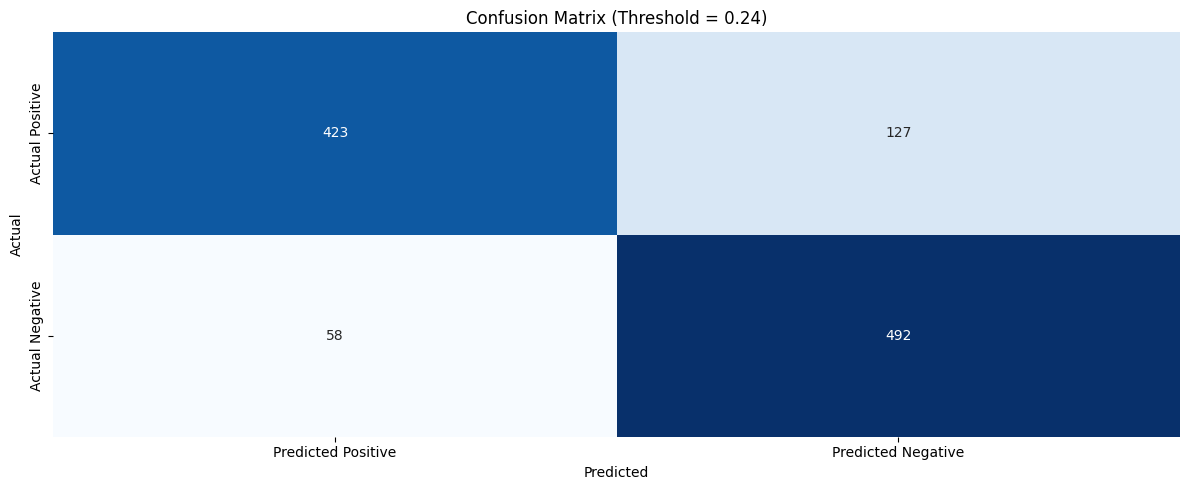

In [7]:
trainer = TFRecDropout([MODELS[6], MODELS[9]], DATASET, VALDS, WEIGHTS, THRESHOLD,200)
trainer.Validate((0.0, 0.7, 0.0, 0.3), (0.6, 0.4), 0.24)

Training ArcFace


evaluating images: 100%|██████████| 110/110 [20:18<00:00, 11.07s/it]


plotting
Model:  ArcFace
Threshold: 0.18
F1 score:  0.8454148471615719
Accuracy:  0.8390909090909091
weight [(0.0, 0.0, 0.0, 1.0), (0.0, 0.0, 0.1, 0.9), (0.0, 0.0, 0.2, 0.8), (0.0, 0.0, 0.3, 0.7), (0.0, 0.0, 0.4, 0.6), (0.0, 0.0, 0.5, 0.5), (0.0, 0.0, 0.6, 0.4), (0.0, 0.0, 0.7, 0.3), (0.0, 0.0, 0.8, 0.2), (0.0, 0.0, 0.9, 0.1), (0.0, 0.0, 1.0, 0.0), (0.0, 0.1, 0.0, 0.9), (0.0, 0.1, 0.1, 0.8), (0.0, 0.1, 0.2, 0.7), (0.0, 0.1, 0.3, 0.6), (0.0, 0.1, 0.4, 0.5), (0.0, 0.1, 0.5, 0.4), (0.0, 0.1, 0.6, 0.3), (0.0, 0.1, 0.7, 0.2), (0.0, 0.1, 0.8, 0.1), (0.0, 0.1, 0.9, 0.0), (0.0, 0.2, 0.0, 0.8), (0.0, 0.2, 0.1, 0.7), (0.0, 0.2, 0.2, 0.6), (0.0, 0.2, 0.3, 0.5), (0.0, 0.2, 0.4, 0.4), (0.0, 0.2, 0.5, 0.3), (0.0, 0.2, 0.6, 0.2), (0.0, 0.2, 0.8, 0.0), (0.0, 0.3, 0.0, 0.7), (0.0, 0.3, 0.1, 0.6), (0.0, 0.3, 0.2, 0.5), (0.0, 0.3, 0.3, 0.4), (0.0, 0.3, 0.4, 0.3), (0.0, 0.3, 0.5, 0.2), (0.0, 0.3, 0.7, 0.0), (0.0, 0.4, 0.0, 0.6), (0.0, 0.4, 0.1, 0.5), (0.0, 0.4, 0.2, 0.4), (0.0, 0.4, 0.3, 0.3), (0.0, 0.4, 

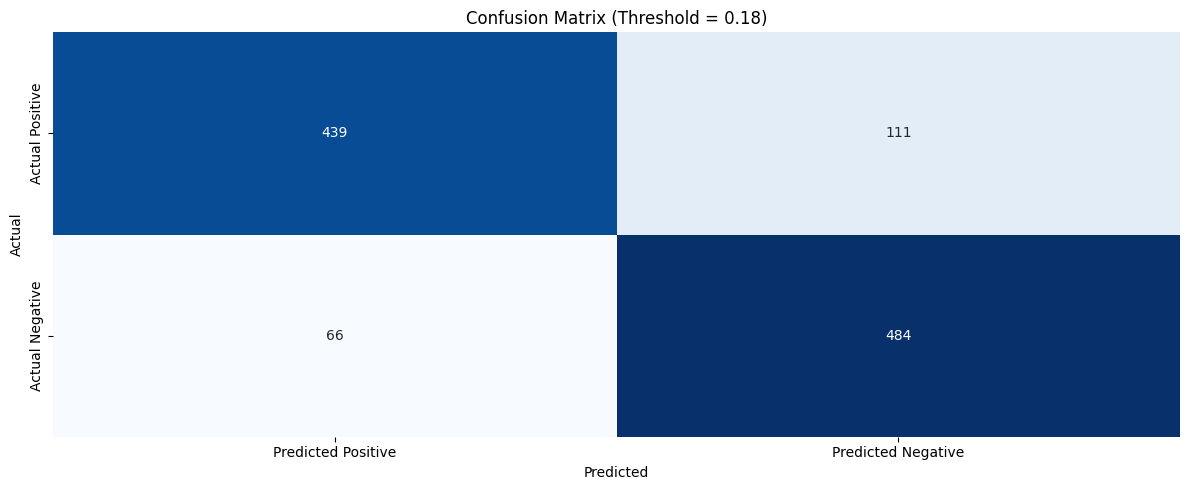

In [ ]:
# M = MODELS[6]
# trainer = TFSensUnFreezed(M, DATASET, VALDS, Ss, MIN_ID, WEIGHTS)
# print("Training", M)
# trainer.Validate(0.18, 1.07, 2, [0.0, 0.8, 0.0, 0.2])
# #trainer.train(THRESHOLD)